Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/laoj/Documents/Github/pymc3/pymc3/model.py:388: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pot1]
100%|██████████| 1000/1000 [00:02<00:00, 337.04it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '4581' (I am process '4582')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting fo

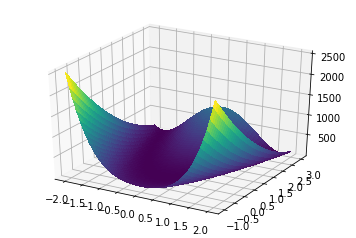

In [1]:
%pylab inline
import matplotlib.pylab as plt
from mpl_toolkits import mplot3d
import numpy as np
import pymc3 as pm

def cust_logp(z):
    return -(1.-z[0])**2 - 100.*(z[1] - z[0]**2)**2

grid = np.mgrid[-2:2:100j,-1:3:100j]
Z = -np.asarray([cust_logp(g) for g in grid.reshape(2, -1).T])
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(grid[0], grid[1], Z.reshape(100,100), cmap='viridis',
                       linewidth=0, antialiased=False)

with pm.Model() as m:
    pm.DensityDist('pot1', logp=cust_logp, shape=(2,))
    tr1 = pm.sample(500, step=pm.NUTS())['pot1']
    tr2 = pm.sample(500, step=pm.Metropolis())['pot1']
    tr3 = pm.fit(n=40000, method='fullrank_advi').sample(500)['pot1'] #VI, cause whynot

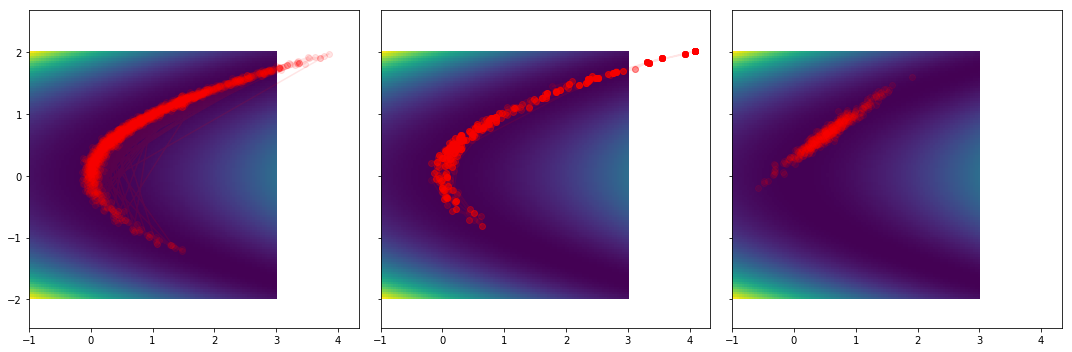

In [2]:
import matplotlib.pylab as plt
_, ax = plt.subplots(1,3,figsize=(15,5), sharex=True, sharey=True)
ax[0].imshow(Z.reshape(100,100), extent=[-1,3,-2,2,]);
ax[0].plot(tr1[:,1], tr1[:,0], 'ro-',alpha=.1)
ax[1].imshow(Z.reshape(100,100), extent=[-1,3,-2,2,]);
ax[1].plot(tr2[:,1], tr2[:,0], 'ro-',alpha=.1)
ax[2].imshow(Z.reshape(100,100), extent=[-1,3,-2,2,]);
ax[2].plot(tr3[:,1], tr3[:,0], 'ro', alpha=.1)
plt.tight_layout()

In [3]:
with pm.Model():
    pm.DensityDist('pot1', logp=cust_logp, shape=(2,))
    minimal=pm.find_MAP()
minimal

logp = -0.00017766, ||grad|| = 0.58277: 100%|██████████| 26/26 [00:00<00:00, 3097.19it/s]  


{'pot1': array([0.99999971, 0.9999994 ])}

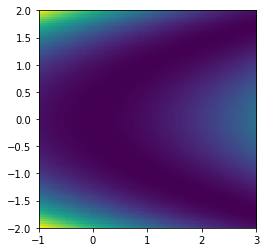

In [4]:
plt.imshow(Z.reshape(100,100), extent=[-1,3,-2,2,]);

# Basic HMC

In [5]:
with m:
    hmc = pm.HamiltonianMC()

def showstep(hmc, q0, model, epsilon=.025, n_steps=20):
    size = model.ndim
    hmc.integrator._logp_dlogp_func.set_extra_values({})

    post_evo = np.zeros((n_steps+1, size))
    post_evo[0, :] = q0

    p0 = hmc.potential.random()
    start = hmc.integrator.compute_state(q0, p0)

    state = start
    for i in range(n_steps):
        state = hmc.integrator.step(epsilon, state)
        post_evo[i+1, :]=state.q
    energy_change = start.energy - state.energy
    return energy_change, state, start, post_evo

    
q0 = pm.floatX(np.asarray([-1, 2]))
energy_change, state, start, post_evo = showstep(hmc, q0, m, epsilon=.025, n_steps=20)
print(start)
print(state)

State(q=array([-1.,  2.]), p=array([-2.02887111,  0.02989907]), v=array([-2.02887111,  0.02989907]), q_grad=array([-396., -200.]), energy=106.05860596885861)
State(q=array([-0.0766879 , -0.89850531]), p=array([ 5.15633314, -3.34635432]), v=array([ 5.15633314, -3.34635432]), q_grad=array([ 29.89556993, 180.8772687 ]), energy=101.84365198926726)


/home/laoj/Documents/Github/pymc3/pymc3/model.py:388: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):


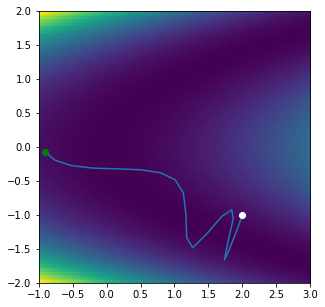

In [6]:
metrop_select = pm.step_methods.arraystep.metrop_select

def plotpost(energy_change, state, start, post_evo):
    q, accept = metrop_select(energy_change, state.q, start.q)
    colorall = ['r', 'g']
    _, ax = plt.subplots(1, 1, figsize=(5,5))
    ax.imshow(Z.reshape(100,100), extent=[-1,3,-2,2,])
    ax.plot(post_evo[:, 1], post_evo[:, 0]);
    ax.plot(post_evo[0, 1], post_evo[0, 0], 'wo');
    ax.plot(post_evo[-1, 1], post_evo[-1, 0], 'o', color=colorall[accept]);
    return q
q1 = plotpost(energy_change, state, start, post_evo)

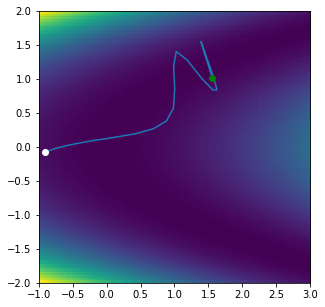

In [7]:
q0 = q1
energy_change, state, start, post_evo = showstep(hmc, q0, m, epsilon=.025, n_steps=20)
q1 = plotpost(energy_change, state, start, post_evo)

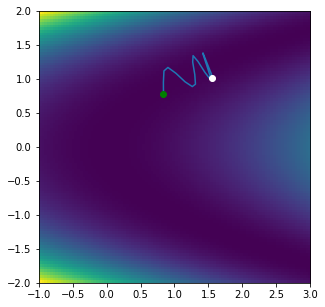

In [8]:
q0 = q1
energy_change, state, start, post_evo = showstep(hmc, q0, m, epsilon=.025, n_steps=20)
q1 = plotpost(energy_change, state, start, post_evo)

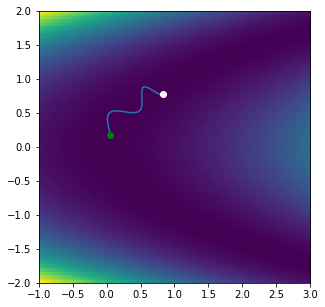

In [9]:
q0 = q1
energy_change, state, start, post_evo = showstep(hmc, q0, m, epsilon=.025, n_steps=20)
q1 = plotpost(energy_change, state, start, post_evo)

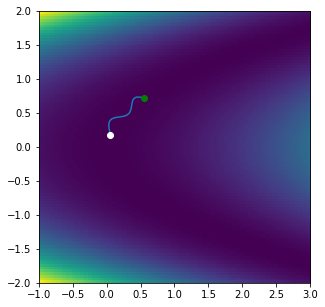

In [10]:
q0 = q1
energy_change, state, start, post_evo = showstep(hmc, q0, m, epsilon=.025, n_steps=20)
q1 = plotpost(energy_change, state, start, post_evo)

In [11]:
with m:
    hmc = pm.HamiltonianMC(path_length=.5, step_scale=.025)

/home/laoj/Documents/Github/pymc3/pymc3/model.py:388: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):


In [16]:
hmc._hamiltonian_step(start, q0, hmc.step_size)

HMCStepData(end=State(q=array([0.4911901 , 0.32915894]), p=array([1.20384469, 1.11028984]), v=array([1.20384469, 1.11028984]), q_grad=array([ 18.28614112, -17.57824667]), energy=2.372367192509291), accept_stat=0.9809180486449784, divergence_info=None, stats={'accept': 0.9809180486449784, 'energy_error': -0.01926636149451344, 'accepted': True, 'n_steps': 14, 'energy': 2.372367192509291, 'path_length': 0.31099387035748094})

In [12]:
int(hmc.path_length / hmc.step_size)

23

Sequential sampling (1 chains in 1 job)
HamiltonianMC: [pot1]
100%|██████████| 500/500 [00:00<00:00, 1465.01it/s]
The acceptance probability does not match the target. It is 0.9683166660207335, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


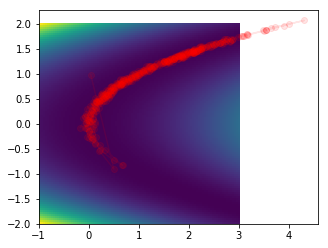

In [13]:
with m:
    trh = pm.sample(500, step=hmc, tune=0, chains=1, start=dict(pot1=np.asarray([-1, 2])))['pot1']

_, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(Z.reshape(100,100), extent=[-1,3,-2,2,])
ax.plot(trh[:,1], trh[:,0], 'ro-',alpha=.1);

# Tree building in NUTS

In [14]:
with m:
    nuts = pm.NUTS()

In [80]:
nuts.integrator._logp_dlogp_func.set_extra_values({})
p0 = nuts.potential.random()
q0 = pm.floatX(np.asarray([-1, 2]))
start = nuts.integrator.compute_state(q0, p0)
step_size = .001
max_treedepth = 15
tree = pm.hmc.nuts._Tree(len(p0), nuts.integrator, start, step_size, nuts.Emax)
tree.left = start
for i in range(max_treedepth):
    direction = pm.hmc.nuts.logbern(np.log(0.5)) * 2 - 1
    diverging_info, turning = tree.extend(direction)
    q, q_grad = tree.proposal.q, tree.proposal.q_grad
    if diverging_info or turning:
        if diverging_info:
            print('Divergence at step %s'%(i))
        if turning:
            print('Turning at step %s'%(i))
        break

Turning at step 3


In [93]:
tree.

State(q=array([-1.,  2.]), p=array([ 0.8170051 ,  1.28127452]), v=array([ 0.8170051 ,  1.28127452]), q_grad=array([-396., -200.]), energy=105.15458086720403)

In [40]:
tree.proposal.q

array([-1.09115363,  1.22875976])